In [1]:

!pip install tqdm
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


gpg: keybox '/tmp/tmpupyhb40w/pubring.gpg' created
gpg: /tmp/tmpupyhb40w/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [2]:
from google.colab import auth
auth.authenticate_user()


from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


··········


In [3]:

!mkdir -p drive
!google-drive-ocamlfuse drive



fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [4]:
print('Files in Drive:')
!ls drive/Dataset/

Files in Drive:
classifier.ipynb	  melanoma			    Untitled0.ipynb
gt			  others			    Untitled1.ipynb
gt.npy			  Preprocessing_segmentation.ipynb
Image_segmentation.ipynb  total_images.npy


In [5]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
%matplotlib inline

In [6]:
import scipy.io as scio
import numpy as np    
import os,h5py
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub

In [7]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

In [8]:
x = np.load('drive/Dataset/all_images.npy')

In [9]:
y=np.load('drive/Dataset/ground_truth.npy')

In [10]:
x.shape

(2000, 256, 256, 3)

In [11]:
y.shape

(2000, 256, 256)

In [12]:
train_indices = np.random.choice(2000,1500,replace = False)
print(sorted(train_indices))
x_train_images = []
y_train_labels = [] 
for i in train_indices:
    x_train_images.append(x[i])
    y_train_labels.append(y[i])

test_indices = [xy for xy in range(2000) if xy not in train_indices]
print(test_indices)
x_test_images = []
y_test_labels = []

for i in test_indices:
    x_test_images.append(x[i])
    y_test_labels.append(y[i])

[1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 74, 75, 76, 77, 78, 79, 82, 84, 86, 87, 89, 90, 91, 92, 93, 96, 97, 98, 101, 103, 104, 105, 106, 108, 109, 110, 111, 112, 114, 115, 116, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 133, 134, 135, 136, 137, 138, 140, 141, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 193, 195, 196, 197, 199, 200, 201, 202, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 236, 237, 238, 240, 243, 245, 246, 247, 248, 249, 250, 254, 255, 256, 257, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270, 272, 273, 276, 277, 278, 279, 281, 2

In [13]:
x_train = np.array(x_train_images)

In [14]:
x_train.shape

(1500, 256, 256, 3)

In [19]:
x_test = np.array(x_test_images)

In [20]:
x_test.shape

(500, 256, 256, 3)

In [21]:
y_train = np.array(y_train_labels)

In [22]:
y_train.shape

(1500, 256, 256)

In [23]:
y_test = np.array(y_test_labels)

In [24]:
y_test.shape

(500, 256, 256)

In [25]:
y_test.dtype

dtype('float64')

In [26]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [29]:
rows = 256
cols = 128

In [30]:
data_shape = 216*64
weight_decay = 0.0001

In [31]:
# Defines the input tensor
inputs = Input(shape=(None,None,3))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
#L3 = Lambda(maxpool_1,output_shape = shape)(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
#L6 = Lambda(maxpool_2,output_shape = shape)(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L9 = Activation('relu')(L8)
L10 = Conv2D(128,(3,3),dilation_rate= (2,2), padding = "same", activation='relu', name = "conv_dil_1")(L9)
L11 = BatchNormalization()(L10)
L12 = Activation('relu')(L11)
L13 = Conv2D(128,(3,3),dilation_rate= (4,4), padding = "same", activation='relu', name = "conv_dil_2")(L12)
L14 = BatchNormalization()(L13)
L15 = Activation('relu')(L14)
L16 = Conv2D(128,(3,3),dilation_rate= (8,8), padding = "same", activation='relu', name = "conv_dil_3")(L15)
L17 = BatchNormalization()(L16)
L18 = Activation('relu')(L17)
L19 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_1")(L6)
L20 = Add()([L18,L19])
L21 = UpSampling2D( size = (2,2)) (L20)
#L21 = Deconvolution2D(128, kernel_size = (3,3), strides = (2,2), activation = "relu", 
 #                     name = "ct_deconv_1", padding = "same")(L20)
L21 = Conv2D(128,(3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L21)
L22 = BatchNormalization()(L21)
L23 = Activation('relu')(L22)
L24 = Conv2D(128,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay),
             name="skip_conv_2")(L3)
L24 = Add()([L23,L24])
L25 = UpSampling2D(size = (2,2))(L24)
L25 = Conv2D(64, (3,3), padding = "same", kernel_regularizer=regularizers.l2(weight_decay))(L25)
#L25 = Deconvolution2D(64, kernel_size = (3,3), strides = (2,2), activation = "relu", 
 #                     name = "ct_deconv_2", padding = "same")(L24)
#L25 = 
L26 = BatchNormalization()(L25)
L27 = Activation('relu')(L26)
L28 = Conv2D(1,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L27)#

L30 = Activation('sigmoid')(L28)
model = Model(inputs = inputs, outputs = L30)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 6 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [32]:
x_train.shape

(1500, 256, 256, 3)

In [33]:
x_test.shape

(500, 256, 256, 3)

In [34]:
y_train.shape

(1500, 256, 256)

In [36]:
y_train = y_train.reshape(y_train.shape[0],256,256,1)

In [37]:
y_test = y_test.reshape(y_test.shape[0],256,256,1)

In [38]:
smooth = 1

In [39]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [40]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [41]:
def customized_loss(y_true,y_pred):
    return (1*K.binary_crossentropy(y_true, y_pred))+(0.5*dice_coef_loss(y_true, y_pred))

In [42]:
optimiser = optimizers.Adam(lr = 0.01)

In [43]:
model.compile(optimizer=optimiser,loss=dice_coef_loss,metrics=['accuracy',dice_coef])

In [44]:
#Defining Callback functions which will be called by model during runtime when specified condition satisfies
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('segmentation_lr_e2_bs4.csv')
model_chekpoint = ModelCheckpoint("segmentation_lr_e2_bs4.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [45]:
model.fit(x_train,y_train,batch_size=4,epochs=20,validation_data=(x_test, y_test),callbacks=[lr_reducer, csv_logger,model_chekpoint])

Train on 1500 samples, validate on 400 samples
Epoch 1/50
1500/1500 [==============================] - 13s 8ms/step - loss: -0.2771 - dice_coef: 0.2771 - val_loss: -0.2881 - val_dice_coef: 0.2881
Epoch 2/50
1500/1500 [==============================] - 9s 6ms/step - loss: -0.2802 - dice_coef: 0.2802 - val_loss: -0.2911 - val_dice_coef: 0.2911
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/step - loss: -0.2847 - dice_coef: 0.2847 - val_loss: -0.3009 - val_dice_coef: 0.3009
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/step - loss: -0.3274 - dice_coef: 0.3274 - val_loss: -0.3596 - val_dice_coef: 0.3596
Epoch 5/50
448/1500 [=======>......................] - ETA: 6s - loss: -0.3524 - dice_coef: 0.3524 1600/1600 [==============================] - 9s 6ms/step - loss: -0.3704 - dice_coef: 0.3704 - val_loss: -0.4395 - val_dice_coef: 0.4395
Epoch 6/50
1500/1500 [==============================] - 9s 6ms/step - loss: -0.5459 - dice_coef: 0.5459 - val_loss: -0.5764 

In [55]:
gt = y_test[0].reshape((256,256))
testing_image = x_test[0].reshape((1,256,256,3))
prediction = model.predict(testing_image)
prediction = prediction.reshape((256,256))
sample = prediction > 0.5

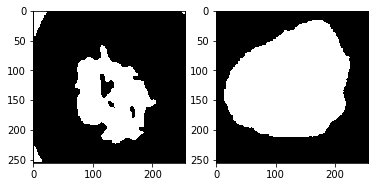

In [65]:
plt.subplot(1,2,1)
plt.imshow(sample, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(gt, cmap = "gray")

In [66]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Score:', score[1])

Score: 0.746851354987561